#### Importing libraries

In [36]:
# importing libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [37]:
# importing data
path = r'C:\Users\Richárd\Desktop\CareerFoundry\Data Immersion\Achievement 6\project\Data'
supply_chain =  pd.read_pickle(os.path.join(path, 'clean_supply_chain_v2.pkl'))

In [38]:
# formatting date of oders into date only to a new column
supply_chain['date'] = pd.to_datetime(supply_chain['order_date'])

In [39]:
supply_chain['date'] = supply_chain['date'].dt.normalize()

In [40]:
supply_chain['date'].head()

0   2018-01-31
1   2018-01-13
2   2018-01-13
3   2018-01-13
4   2018-01-13
Name: date, dtype: datetime64[ns]

In [41]:
# creating a subset of number of orders
time_series = supply_chain[['date', 'customer_id']].groupby('date').agg('count')

In [42]:
time_series.head()

,customer_id
date,
2015-01-01,168
2015-01-02,154
2015-01-03,179
2015-01-04,191
2015-01-05,160


In [43]:
time_series.isnull().sum()

customer_id    0
dtype: int64

In [44]:
# visualizing the initial subset
# using plotly to provide some interactivity
import plotly.express as px 

fig = px.line(data_frame=time_series)
fig.show()

- After Oct 2. 2017. there is some strangeness going on, it looks like it is necessary to remove the part after 2017.Oct.02, since there is no way having exactly 69 orders from October until January is correct
- Moreover, it seems it wold be more helpful to smoothe the data to a monthly level

In [45]:
# resetting index to filter the data
time_series = time_series.reset_index()

In [46]:
time_series.columns

Index(['date', 'customer_id'], dtype='object')

In [47]:
# removing period starting from 2017 Oct 1
time_series = time_series.loc[time_series['date'] < '2017-10-01']

In [48]:
# smoothing
dates = []
for i in time_series['date'].astype(str):
    dates.append(i[:7])

In [49]:
time_series['date'] = dates

In [50]:
time_series['date'] = pd.to_datetime(time_series['date'])

In [51]:
time_series = time_series.groupby('date').sum('customer_id')
time_series.columns

Index(['customer_id'], dtype='object')

In [52]:
fig = px.line(data_frame=time_series)
fig.show()

- That looks much more useful!

#### Time series analysis

In [53]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(time_series, model='additive')

In [54]:
# Defining a fixed size for all special charts.
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

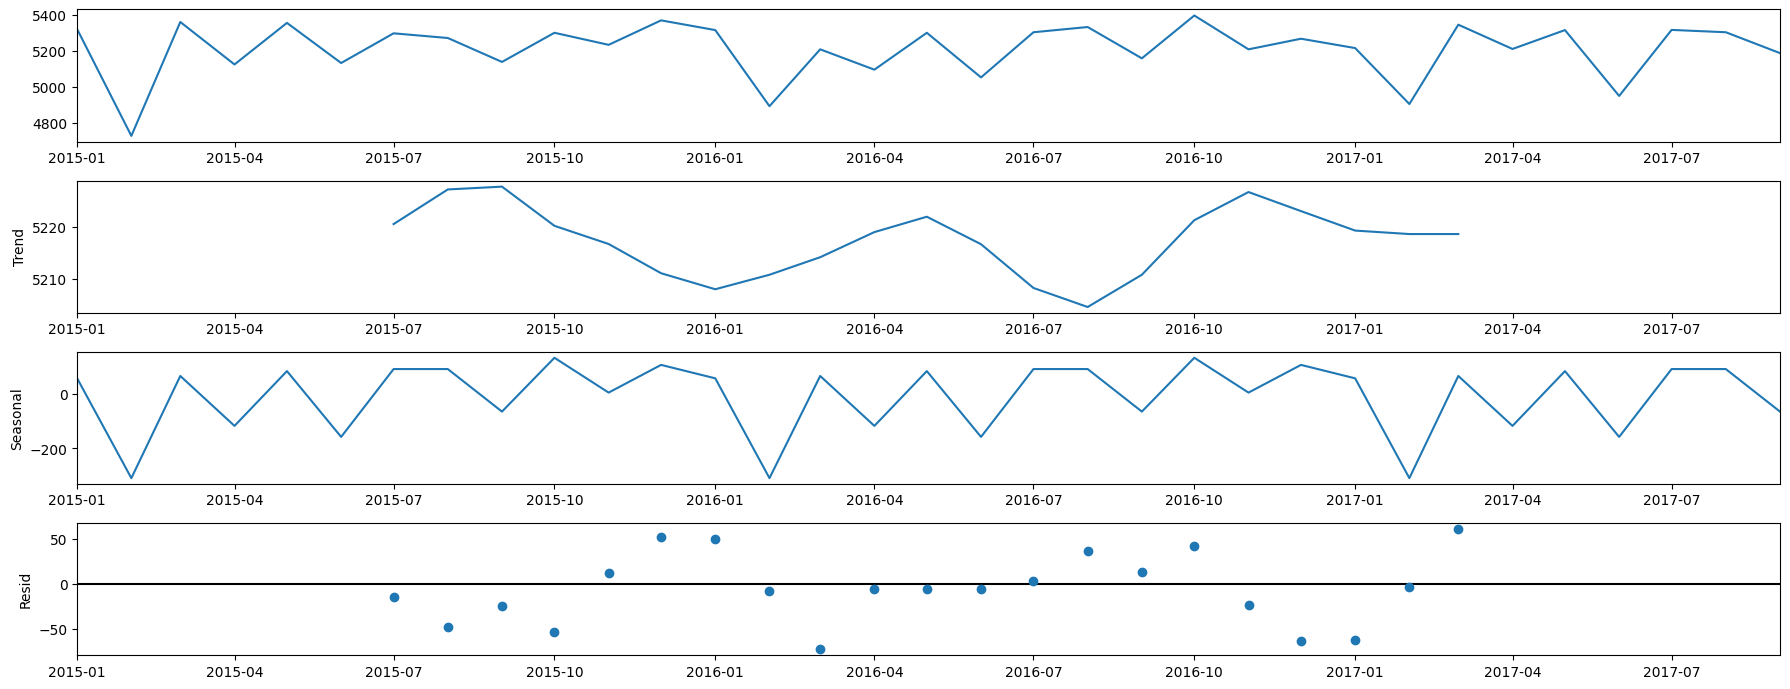

In [55]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Observations
- Trend: seems like only the middle of the data has any real trend to it, and nothing too significant
- There is a distinct seasonality to the data, mainly in the form of post-christmas dip in number of orders
- Theres seeems to be some noise to the data even after the monthly smoothing - due to the shorness of thetimeframe, quaterly smoothing seems like an overkill

In [56]:
# conducting Dicery-Fuller test to check stationarity
# importing the test function
from statsmodels.tsa.stattools import adfuller


In [57]:
# defining function to conduct the actual test
def dickey_fuller(timeseries):
    print ('Results of Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [58]:
# applying the test
dickey_fuller(time_series['customer_id'])

Results of Dickey-Fuller Stationarity test:
Test Statistic                 -5.146077
p-value                         0.000011
Number of Lags Used            10.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


#### Observations
- p-value is 0.000011, so the results are statistically significant
- The test Statistic is -5.146077 which is smaller tha all the critical values - so th data is stationary enough!

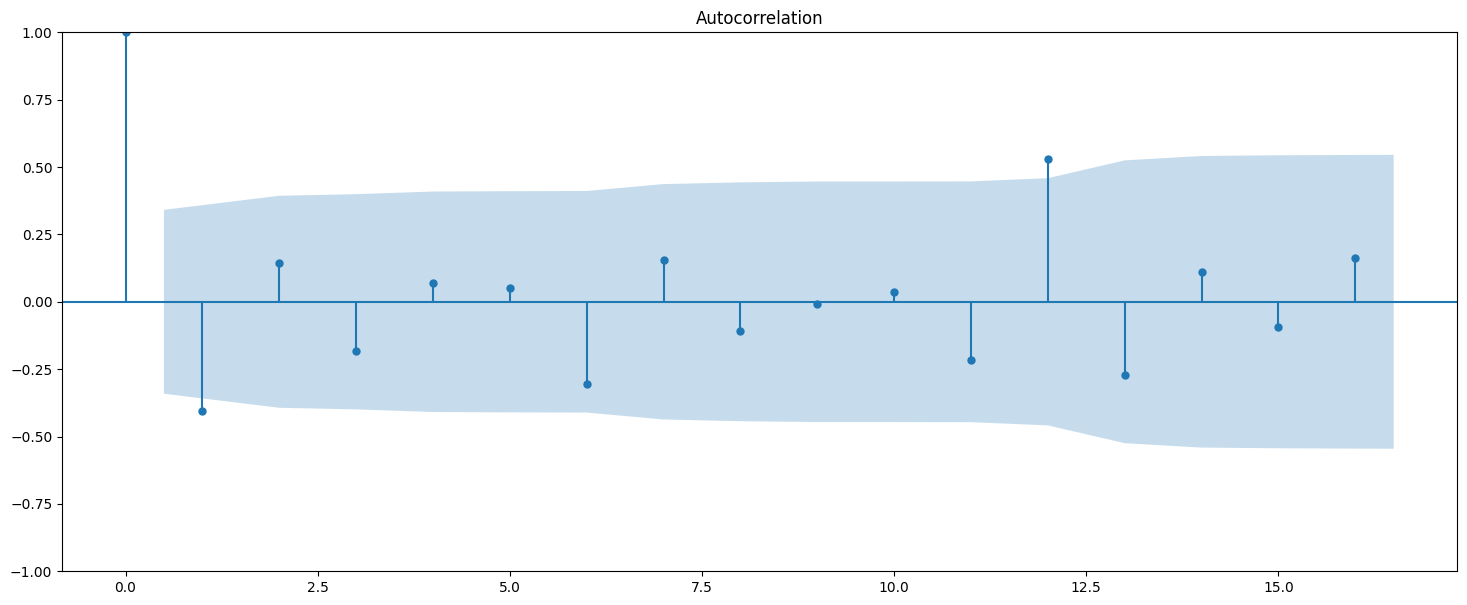

In [59]:
# checking autocorrelation
# importing autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_series)
plt.show()

Only very little autocorrelation is present.